# Keras with Tensorflow Course - Part-3
## MobileNet Image Classification
DeepLizard.com

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import imagenet_utils
from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
mobile = tf.keras.applications.mobilenet.MobileNet()

17227776/17225924 [==============================] - 16s 1us/step


In [10]:
def prepare_image(file):
    img_path = 'datasets/MobileNet-samples'
    img = image.load_img(img_path + file, target_size=(224,224))
    img_array = image.img_to_array(img)
    img_array_expanded_dims = np.expand_dims(img_array, axis=0)
    return tf.keras.applications.mobilenet.preprocess_input(img_array_expanded_dims)

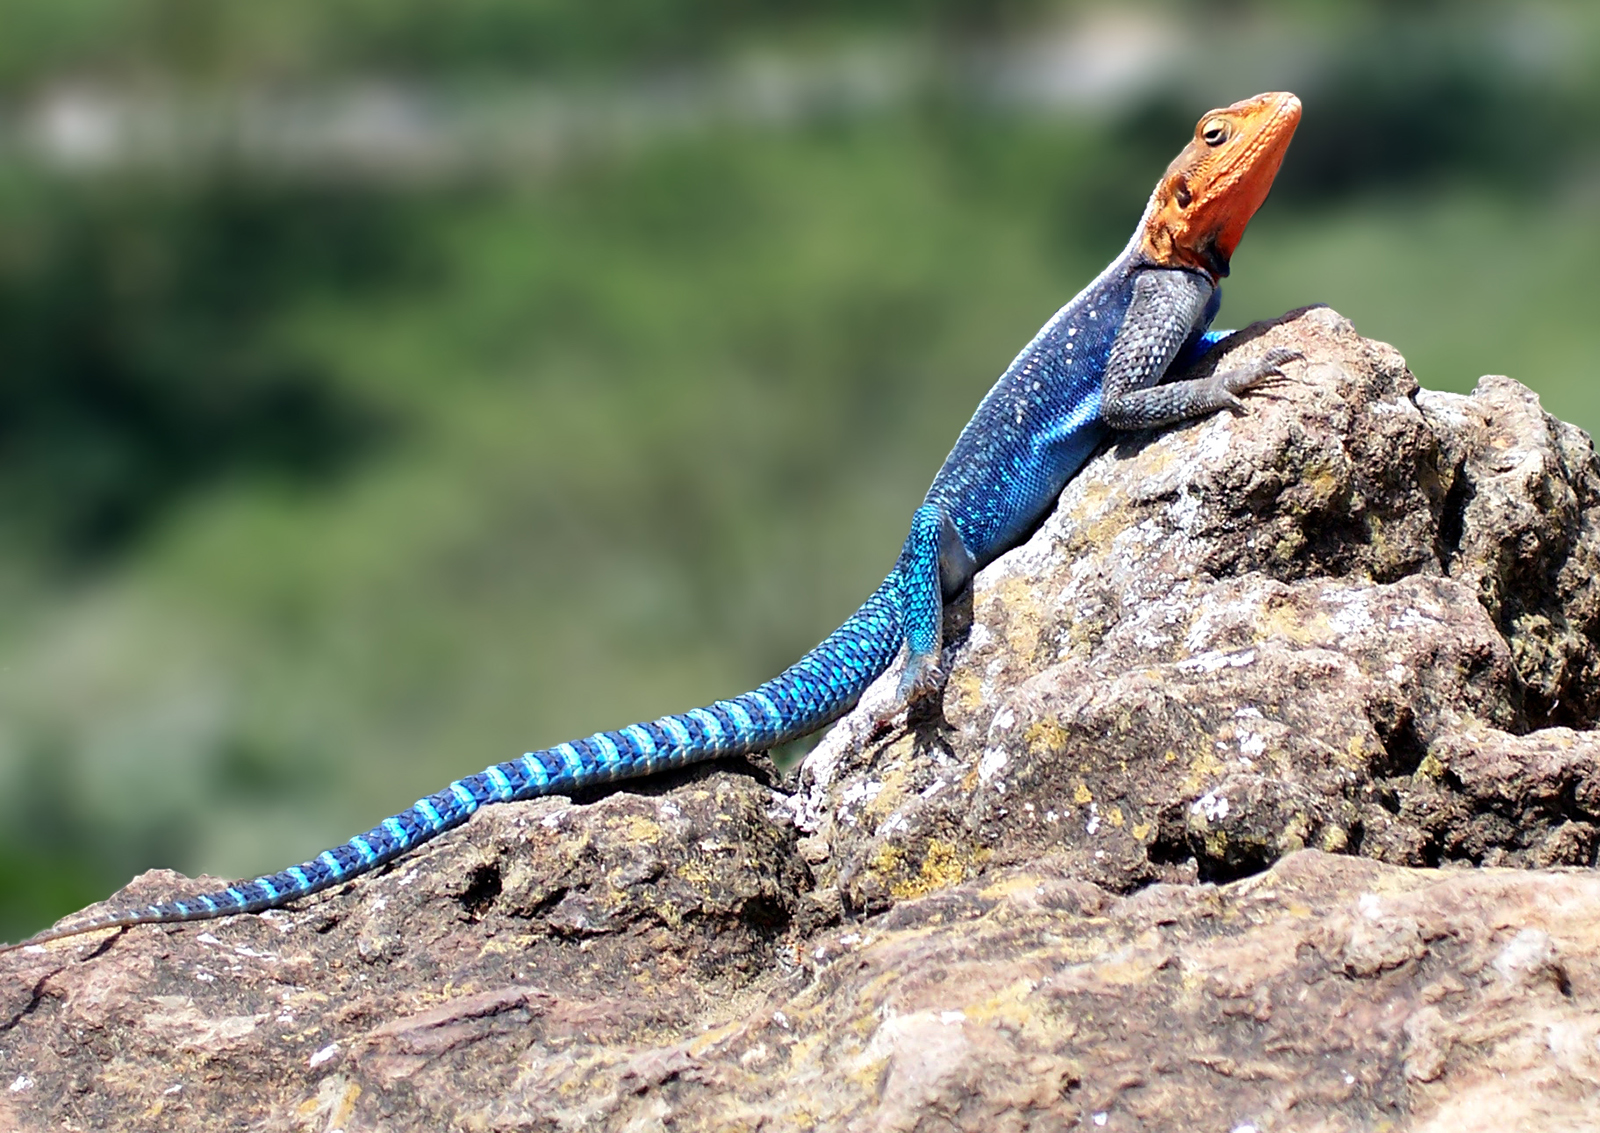

In [12]:
from IPython.display import Image
Image(filename='datasets/MobileNet-samples/1.png',width=300,height=200)

In [14]:
preprocessed_image = prepare_image('/1.png')

In [15]:
predictions = mobile.predict(preprocessed_image)
results = imagenet_utils.decode_predictions(predictions)
results

40960/35363 [==================================] - 0s 0us/step


[[('n01687978', 'agama', 0.99994934),
  ('n01693334', 'green_lizard', 4.3851338e-05),
  ('n01685808', 'whiptail', 4.5993847e-06),
  ('n01682714', 'American_chameleon', 1.050847e-06),
  ('n01677366', 'common_iguana', 2.641417e-07)]]

# Fine Tune MobileNet on sign-language digits

In [37]:
#Organise data into train, valid and test directories

os.chdir('datasets/Sign-Language-Digits')
if os.path.isdir('train/0/') is False:
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')
    
    for i in range(0, 10):
        shutil.move(f'{i}','train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')
        
        valid_samples = random.sample(os.listdir(f'train/{i}'),30)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}',f'valid/{i}')
            
        test_samples = random.sample(os.listdir(f'train/{i}'),5)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}',f'test/{i}')
            
os.chdir('../..')

In [38]:
train_path = 'datasets/Sign-Language-Digits/train'
valid_path = 'datasets/Sign-Language-Digits/valid'
test_path = 'datasets/Sign-Language-Digits/test'

In [39]:
train_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=train_path,target_size=(224,224), batch_size=10)

valid_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=valid_path,target_size=(224,224), batch_size=10)

test_batches = ImageDataGenerator(preprocessing_function = tf.keras.applications.mobilenet.preprocess_input) \
    .flow_from_directory(directory=test_path,target_size=(224,224), batch_size=10, shuffle = False)

Found 1712 images belonging to 10 classes.
Found 300 images belonging to 10 classes.
Found 50 images belonging to 10 classes.


## Modify Model

In [40]:
mobile = tf.keras.applications.mobilenet.MobileNet()

In [41]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

## Get all of the layers upto the 6th last layer (fine tuning the MobileNet model)

In [42]:
x = mobile.layers[-6].output
output = Dense(units=10,activation='softmax')(x)

In [43]:
model = Model(inputs=mobile.input, outputs=output)

In [44]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [45]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [46]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(x=train_batches, validation_data=valid_batches, epochs=10, verbose=2)

Epoch 1/10
172/172 - 104s - loss: 0.6411 - accuracy: 0.8014 - val_loss: 0.6382 - val_accuracy: 0.7700
Epoch 2/10
172/172 - 113s - loss: 0.1077 - accuracy: 0.9866 - val_loss: 0.1163 - val_accuracy: 0.9733
Epoch 3/10
172/172 - 95s - loss: 0.0632 - accuracy: 0.9907 - val_loss: 0.0818 - val_accuracy: 0.9800
Epoch 4/10
172/172 - 83s - loss: 0.0370 - accuracy: 0.9965 - val_loss: 0.0594 - val_accuracy: 0.9900
Epoch 5/10
172/172 - 99s - loss: 0.0230 - accuracy: 0.9982 - val_loss: 0.0556 - val_accuracy: 0.9900
Epoch 6/10


KeyboardInterrupt: 